In [19]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt

In [20]:
#testing parallel run of shorter simulations for Gershman 2012's model, p is the number of simulations to run in parallel

In [21]:
def p_w_new(index,w,x_l,x_r,pi_l,pi_r,beta,var_l,var_r,b,tau,p):
    #index: the index of the weight to be sampled, tuple (i,j)
    #var_1: right mode; var_0: left mode
    i,j = index[0],index[1]
    s_n = w[:,i,j]*x_l[:,i,j]+(1-w[:,i,j])*x_r[:,i,j]
    E_s = (b[:,i,j]-s_n)**2
    w_extended = np.concatenate((w[:,:,0].reshape(p,-1,1),w,w[:,:,-1].reshape(p,-1,1)),axis=2)
    w_extended = np.concatenate((w_extended[:,0,:].reshape(p,1,-1),w_extended,w_extended[:,-1,:].reshape(p,1,-1)),axis=1)
    E_s = E_s + beta*((w_extended[:,i+1,j+1]-w_extended[:,i,j+1])**2+(w_extended[:,i+1,j+1]-w_extended[:,i+1,j])**2)
    E_s = E_s + beta*((w_extended[:,i+1,j+1]-w_extended[:,i+2,j+1])**2+(w_extended[:,i+1,j+1]-w_extended[:,i+1,j+2])**2)
    E_x = 1/(2*var_l)*pi_l[:,i,j]*(x_l[:,i,j]-s_n)**2+1/(2*var_r)*pi_r[:,i,j]*(x_r[:,i,j]-s_n)**2
    return np.exp(-tau*(E_x+E_s))

In [22]:
def p_pi_l_new(index,w,x_l,x_r,pi_l,var_l,b,tau,gamma,p):
    #sparse coefficient alpha TBC
    i,j = index[0],index[1]
    s_n = w[:,i,j]*x_l[:,i,j]+(1-w[:,i,j])*x_r[:,i,j]
    E_xl = 1/(2*var_l)*pi_l[:,i,j]*(x_l[:,i,j]-s_n)**2
    pi_extended = np.concatenate((pi_l[:,:,0].reshape(p,-1,1),pi_l,pi_l[:,:,-1].reshape(p,-1,1)),axis=2)
    pi_extended = np.concatenate((pi_extended[:,0,:].reshape(p,1,-1),pi_extended,pi_extended[:,-1,:].reshape(p,1,-1)),axis=1)
    #E_pi_l = alpha*(pi_extended[i+2,j+1]+pi_extended[i+1,j+2]+pi_extended[i,j+1]+pi_extended[i+1,j])
    '''E_pi_l = E_pi_l + gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i,j+1])**2+(pi_extended[:i+1,j+1]-pi_extended[:,i+1,j])**2)'''
    E_pi_l = gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i,j+1])**2+(pi_extended[:,i+1,j+1]-pi_extended[:,i+1,j])**2)
    E_pi_l = E_pi_l + gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i+2,j+1])**2+(pi_extended[:,i+1,j+1]-pi_extended[:,i+1,j+2])**2)
    return np.exp(-tau*(E_xl+E_pi_l))

In [23]:
def p_pi_r_new(index,w,x_l,x_r,pi_r,var_r,b,tau,gamma,p):
    #sparse coefficient alpha TBC
    i,j = index[0],index[1]
    s_n = w[:,i,j]*x_l[:,i,j]+(1-w[:,i,j])*x_r[:,i,j]
    E_xr = 1/(2*var_r)*pi_r[:,i,j]*(x_r[:,i,j]-s_n)**2
    pi_extended = np.concatenate((pi_r[:,:,0].reshape(p,-1,1),pi_r,pi_r[:,:,-1].reshape(p,-1,1)),axis=2)
    pi_extended = np.concatenate((pi_extended[:,0,:].reshape(p,1,-1),pi_extended,pi_extended[:,-1,:].reshape(p,1,-1)),axis=1)
    #E_pi_l = alpha*(pi_extended[i+2,j+1]+pi_extended[i+1,j+2]+pi_extended[i,j+1]+pi_extended[i+1,j])
    '''E_pi_l = E_pi_l + gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i,j+1])**2+(pi_extended[:i+1,j+1]-pi_extended[:,i+1,j])**2)'''
    E_pi_r = gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i,j+1])**2+(pi_extended[:,i+1,j+1]-pi_extended[:,i+1,j])**2)
    E_pi_r = E_pi_r + gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i+2,j+1])**2+(pi_extended[:,i+1,j+1]-pi_extended[:,i+1,j+2])**2)
    return np.exp(-tau*(E_xr+E_pi_r))

In [24]:
def proposal_function_new(z, index, p, sigma = 1):
    #generate a new proposal from the current sample
    #change only one element at a time!
    z_star = z.copy()
    i,j = index[0],index[1]
    z_star[:,i,j] = z_star[:,i,j] + sigma*random.normal(size = (p))
    return z_star

In [25]:
def binary_proposal_new(z,index):
    #p: the probability of switch, to stablize the system
    z_star = z.copy()
    z_star[:,index[0],index[1]] = 1-z[:,index[0],index[1]]
    return z_star

In [26]:
def sample_rejection_w_new(index,w,w_star,x_l,x_r,pi_l,pi_r,beta,var_l,var_r,b,tau,p):
    p_w_cur = p_w_new(index,w,x_l,x_r,pi_l,pi_r,beta,var_l,var_r,b,tau,p)
    p_w_star = p_w_new(index,w_star,x_l,x_r,pi_l,pi_r,beta,var_l,var_r,b,tau,p)
    p_acc = p_w_star/p_w_cur
    p_ran = random.random(p)
    acc = np.sign(p_acc-p_ran).astype('int')
    return acc
    
def sample_rejection_pi_l_new(index,w,x_l,x_r,pi_l,pi_l_star,var_l,b,tau,gamma,p):
    p_pi_l_cur = p_pi_l_new(index,w,x_l,x_r,pi_l,var_l,b,tau,gamma,p)
    p_pi_l_star = p_pi_l_new(index,w,x_l,x_r,pi_l_star,var_l,b,tau,gamma,p)
    p_acc = p_pi_l_star/p_pi_l_cur
    p_ran = random.random(p)
    acc = np.sign(p_acc-p_ran).astype('int')
    return acc
    
def sample_rejection_pi_r_new(index,w,x_l,x_r,pi_r,pi_r_star,var_r,b,tau,gamma,p):
    p_pi_r_cur = p_pi_r_new(index,w,x_l,x_r,pi_r,var_r,b,tau,gamma,p)
    p_pi_r_star = p_pi_r_new(index,w,x_l,x_r,pi_r_star,var_r,b,tau,gamma,p)
    p_acc = p_pi_r_star/p_pi_r_cur
    p_ran = random.random(p)
    acc = np.sign(p_acc-p_ran).astype('int')
    return acc

In [27]:
def simulation_new(var_l,var_r,beta,gamma,alpha,tau,b,dim,p,no_sample):
    #p: no. parallel sampling sequences
    #no. sample: no. samples in each sequence
    #dim: dimension of each MRF
    sampling_order_i = np.arange(dim)
    sampling_order_j = np.arange(dim)

    #set initial condition for w, pi_r, pi_l
    #set visual input x_r, x_l as conflicting input
    x_l = np.ones((p,dim,dim))
    x_r = np.zeros((p,dim,dim))
    w = random.rand(p,dim,dim)
    pi_l = random.randint(0,2,(p,dim,dim))
    pi_r = random.randint(0,2,(p,dim,dim))

    s = []
    for m in range(int(no_sample)):
        #order of sweep is randomnized
        random.shuffle(sampling_order_i)
        random.shuffle(sampling_order_j)
        #the following for loop update on pi_r
        for i in sampling_order_i:
            for j in sampling_order_j:
                index = (i,j)
                pi_r_star = binary_proposal_new(pi_r, index)
                acc_1 = sample_rejection_pi_r_new(index,w,x_l,x_r,pi_r,pi_r_star,var_r,b,tau,gamma,p)
                for j in range(p):
                    if acc_1[j] == 1:
                        pi_r[j,:,:] = pi_r_star[j,:,:]

        #the following for loop update on pi_l
        for i in sampling_order_i:
            for j in sampling_order_j:
                index = (i,j)
                pi_l_star = binary_proposal_new(pi_l, index)
                acc_2 = sample_rejection_pi_l_new(index,w,x_l,x_r,pi_l,pi_l_star,var_l,b,tau,gamma,p)
                for j in range(p):
                    if acc_2[j] == 1:
                        pi_l[j,:,:] = pi_l_star[j,:,:]
    
            #the following for loop update on w
            for i in sampling_order_i:
                for j in sampling_order_j:
                    index = (i,j)
                    w_star = proposal_function_new(w, index, p)
                    acc_3 = sample_rejection_w_new(index,w,w_star,x_l,x_r,pi_l,pi_r,beta,var_l,var_r,b,tau,p)
                    for j in range(p):
                        if acc_3[j] == 1:
                            w[j,:,:] = w_star[j,:,:]
        
        s_i = w*x_l+(1-w)*x_r
        s.append(s_i)
    return np.array(s)

In [28]:
def cov_cal(s,p,no_sample):
    #calculate covariance between nodes, return a dim by dim matrix
    s = np.mean(s,axis=1)
    s=s.reshape(no_sample,-1)
    s_square = np.matmul(s.T,s)
    s_ave = np.mean(s,axis=0)
    s_var = np.std(s,axis=0)
    return (s_square/no_sample-np.matmul(s_ave.reshape(-1,1),s_ave.reshape(1,-1)))/np.matmul(s_var.reshape(-1,1),s_var.reshape(1,-1))

In [29]:
var_0,var_1,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.001,0.001,10,10,0,1/100,0.5*np.ones((200,5,5)),5,200,22000
s_0001_0001 = simulation_new(var_0,var_1,beta,gamma,alpha,tau,b,dim,p,no_sample)
print('done')

done


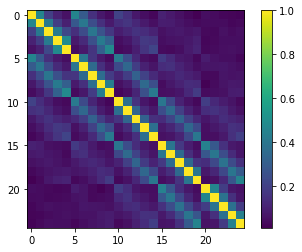

In [32]:
plt.imshow(cov_cal(s_0001_0001,p,no_sample))
plt.colorbar()